##Fangyuan Deng 
##5074
##HW 2

In [ ]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import data and unzip files to folder
!unzip /content/drive/MyDrive/COVID-19_Radiography_Dataset.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7933.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7934.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7935.png  
  inflating: COVID-19_Rad

In [ ]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

In [ ]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]
[['COVID-19_Radiography_Dataset/COVID/images/COVID-1860.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2887.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2216.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3542.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3589.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1555.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2566.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1174.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-939.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3033.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1164.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1744.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-824.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2213.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1477.png', 'COVID-19_Radiography_Dataset/COVID/images/C

In [ ]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [ ]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single covid-19 file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [ ]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [ ]:
len(image_filepaths)

4032

In [ ]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one

4032
(4032, 192, 192, 3)
-0.0
1.0


In [ ]:
len(fnames[2])

1344

In [ ]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
4027,0,0,1
4028,0,0,1
4029,0,0,1
4030,0,0,1


###Visualize images that demonstrate when x-rays demonstrate Covid Positivity and when they do not (You can present visuals of each category in the data if you would like to.).

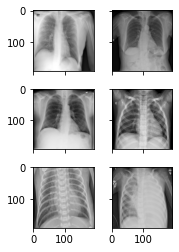

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor(fnames[0][0])
im2 =preprocessor(fnames[0][1])
im3 =preprocessor(fnames[1][0])
im4 =preprocessor(fnames[1][1])
im5 =preprocessor(fnames[2][0])
im6 =preprocessor(fnames[2][1])


fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 2),  # creates 3x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4, im5, im6]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

The images in row 1 are covid positivity. Images in row 2 are normal. Images in row 3 are viral pneumonia.

###Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.


Covid-19 is a highly infectious and rapidly spreading disease. Building the predictive model can be used for early detection and diagnosis, which could result in fewer infections.

In addition, Covid-19 symptoms can be similar to those of other respiratory diseases. This X-Ray image predictive model can help distinguish between Covid-19 and viral pneumonia.

Doctors and patients could benefit from a model like this because it can precisely diagnose Covid-19 in a shorter time and help doctors give effective treatment plans to patients.

###Run at least three prediction models to try to predict x-ray images well. Use transfer learning for at least one of these models. Discuss which models performed better and point out relevant hyper-parameter values for successful models. Submit your best three models to the leader board for the Covid X-ray Diagnostic AI Model Share competition.


In [ ]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [ ]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [ ]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

#Save data
import pickle

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

#Save data
import pickle

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

In [ ]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

###First Keras Convolutional Neural Network Model

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 3, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/3
69/69 [==============================] - 197s 3s/step - loss: 0.7464 - accuracy: 0.6323 - val_loss: 0.5790 - val_accuracy: 0.7577
Epoch 2/3
69/69 [==============================] - 193s 3s/step - loss: 0.5476 - accuracy: 0.7555 - val_loss: 0.5013 - val_accuracy: 0.7687
Epoch 3/3
69/69 [==============================] - 203s 3s/step - loss: 0.4390 - accuracy: 0.8034 - val_loss: 0.4401 - val_accuracy: 0.8033


In [ ]:
model.save("model1.h5", save_format="h5")

In [ ]:
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade
# Restart session Runtime > Restart runtime

In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model1.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 32)        1056      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                    

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f71eea330d0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 46s 1s/step


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                        custom_metadata={"team":"9"})

Insert search tags to help users find your model (optional): model1
Provide any useful notes about your model (optional): model1

Your model has been submitted as model version 98

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,averagepooling2d_layers,conv2d_layers,batchnormalization_layers,dense_layers,maxpooling2d_layers,inputlayer_layers,add_layers,globalaveragepooling2d_layers,zeropadding2d_layers,flatten_layers,concatenate_layers,relu_act,softmax_act,loss,optimizer,memory_size,team,username,version
0,96.36%,96.37%,96.38%,96.36%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,23
1,96.28%,96.27%,96.30%,96.28%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,22
2,95.82%,95.82%,95.88%,95.82%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,20
3,95.58%,95.59%,95.60%,95.58%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,9
4,94.42%,94.42%,94.44%,94.42%,keras,nan,True,Sequential,26.000000,117651.000000,nan,10.000000,9.000000,1.000000,5.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,478136.000000,nan,oliverhegi,78
5,93.73%,93.71%,93.71%,93.72%,keras,True,True,Functional,219.000000,21808931.000000,9.000000,94.000000,94.000000,1.000000,4.000000,1.000000,nan,1.000000,nan,nan,15.000000,94.000000,1.000000,str,Adam,87285904.000000,nan,hal2148,18
6,92.87%,92.86%,92.86%,92.87%,keras,nan,True,Sequential,25.000000,58147.000000,nan,10.000000,9.000000,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,240120.000000,nan,sofiazaidman,82
7,92.72%,92.68%,92.72%,92.71%,keras,nan,True,Sequential,19.000000,3686819.000000,nan,12.000000,nan,1.000000,5.000000,nan,nan,nan,nan,1.000000,nan,12.000000,1.000000,str,Adam,14751136.000000,nan,Chen,87
8,91.71%,91.66%,91.68%,91.71%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,nan,hal2148,14
9,91.48%,91.51%,91.65%,91.48%,keras,nan,True,Sequential,24.000000,3820963.000000,nan,10.000000,8.000000,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15290936.000000,nan,sofiazaidman,62


###Second Keras Convolutional Neural Network

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model2 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='valid', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='valid', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='valid', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='valid', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='valid', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='valid', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model2.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model2.fit(X_train, y_train, 
                    epochs = 3, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/3
69/69 [==============================] - 212s 3s/step - loss: 0.9205 - accuracy: 0.5036 - val_loss: 0.6483 - val_accuracy: 0.6794
Epoch 2/3
69/69 [==============================] - 253s 4s/step - loss: 0.6077 - accuracy: 0.7286 - val_loss: 0.5123 - val_accuracy: 0.7614
Epoch 3/3
69/69 [==============================] - 205s 3s/step - loss: 0.5284 - accuracy: 0.7596 - val_loss: 0.5351 - val_accuracy: 0.7359


In [ ]:
model2.save("model2.h5", save_format="h5")

In [ ]:
# Reload model and data
import tensorflow as tf
model2 = tf.keras.models.load_model('model2.h5',compile=False)
model2.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 190, 190, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 190, 190, 32)      1056      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 95, 95, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 93, 93, 32)        9248      
                                                                 
 conv2d_13 (Conv2D)          (None, 93, 93, 32)        1056      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 46, 46, 32)       0         
 2D)                                                  

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model2, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f71e1df5a60>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model_filepath = "model2.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                        custom_metadata={"team":"9"})

Insert search tags to help users find your model (optional): model2
Provide any useful notes about your model (optional): model2

Your model has been submitted as model version 104

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,averagepooling2d_layers,conv2d_layers,batchnormalization_layers,dense_layers,maxpooling2d_layers,inputlayer_layers,add_layers,globalaveragepooling2d_layers,zeropadding2d_layers,flatten_layers,concatenate_layers,relu_act,softmax_act,loss,optimizer,memory_size,team,username,version
0,96.36%,96.37%,96.38%,96.36%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,23
1,96.28%,96.27%,96.30%,96.28%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,22
2,95.82%,95.82%,95.88%,95.82%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,20
3,95.58%,95.59%,95.60%,95.58%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,9
4,94.42%,94.42%,94.44%,94.42%,keras,nan,True,Sequential,26.000000,117651.000000,nan,10.000000,9.000000,1.000000,5.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,478136.000000,nan,oliverhegi,78
5,93.73%,93.71%,93.71%,93.72%,keras,True,True,Functional,219.000000,21808931.000000,9.000000,94.000000,94.000000,1.000000,4.000000,1.000000,nan,1.000000,nan,nan,15.000000,94.000000,1.000000,str,Adam,87285904.000000,nan,hal2148,18
6,92.87%,92.86%,92.86%,92.87%,keras,nan,True,Sequential,25.000000,58147.000000,nan,10.000000,9.000000,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,240120.000000,nan,sofiazaidman,82
7,92.72%,92.68%,92.72%,92.71%,keras,nan,True,Sequential,19.000000,3686819.000000,nan,12.000000,nan,1.000000,5.000000,nan,nan,nan,nan,1.000000,nan,12.000000,1.000000,str,Adam,14751136.000000,nan,Chen,87
8,92.49%,92.46%,92.50%,92.48%,keras,nan,True,Sequential,30.000000,58339.000000,nan,12.000000,11.000000,1.000000,5.000000,nan,nan,nan,nan,1.000000,nan,12.000000,1.000000,str,Adam,242472.000000,nan,sofiazaidman,100
9,91.71%,91.66%,91.68%,91.71%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,nan,hal2148,14


###Third Transfer Learning Model

In [ ]:
# Create the base model from the pre-trained model VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

base_model = VGG16(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                              

In [ ]:
# Freeze the weights of the VGG16 model so that they are not trained when you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.
base_model.trainable = False

base_model.summary() 

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(112, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)

# define new model
model3 = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model

# summarize
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [ ]:
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model_vgg16.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model3.fit(X_train, y_train,
          epochs = 1, verbose=1,validation_split=.2,callbacks=[mc,red_lr])

69/69 [==============================] - ETA: 0s - loss: 0.7248 - acc: 0.6880 
Epoch 00001: val_acc improved from -inf to 0.66849, saving model to best_model_vgg16.h5
69/69 [==============================] - 1470s 21s/step - loss: 0.7248 - acc: 0.6880 - val_loss: 0.7613 - val_acc: 0.6685 - lr: 0.0100


In [ ]:
model.save("model3.h5", save_format="h5")

In [ ]:
# Reload model and data
import tensorflow as tf
model_vgg16 = tf.keras.models.load_model('model3.h5',compile=False)
model_vgg16.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 32)        1056      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                    

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model_vgg16, framework='keras',
                          transfer_learning= True,
                          deep_learning=True)

with open("model_vgg16.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f71c850ff70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
# Submit Model 3 to Competition Leaderboard
experiment.submit_model(model_filepath = "model_vgg16.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                        custom_metadata={"team":"9"})

Insert search tags to help users find your model (optional): model3
Provide any useful notes about your model (optional): model3

Your model has been submitted as model version 110

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,averagepooling2d_layers,conv2d_layers,batchnormalization_layers,dense_layers,maxpooling2d_layers,inputlayer_layers,add_layers,globalaveragepooling2d_layers,zeropadding2d_layers,flatten_layers,concatenate_layers,relu_act,softmax_act,loss,optimizer,memory_size,team,username,version
0,96.36%,96.37%,96.38%,96.36%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,23
1,96.28%,96.27%,96.30%,96.28%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,22
2,95.82%,95.82%,95.88%,95.82%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,20
3,95.58%,95.59%,95.60%,95.58%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,9
4,94.42%,94.42%,94.44%,94.42%,keras,nan,True,Sequential,26.000000,117651.000000,nan,10.000000,9.000000,1.000000,5.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,478136.000000,nan,oliverhegi,78
5,93.73%,93.71%,93.71%,93.72%,keras,True,True,Functional,219.000000,21808931.000000,9.000000,94.000000,94.000000,1.000000,4.000000,1.000000,nan,1.000000,nan,nan,15.000000,94.000000,1.000000,str,Adam,87285904.000000,nan,hal2148,18
6,92.87%,92.86%,92.86%,92.87%,keras,nan,True,Sequential,25.000000,58147.000000,nan,10.000000,9.000000,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,240120.000000,nan,sofiazaidman,82
7,92.72%,92.68%,92.72%,92.71%,keras,nan,True,Sequential,19.000000,3686819.000000,nan,12.000000,nan,1.000000,5.000000,nan,nan,nan,nan,1.000000,nan,12.000000,1.000000,str,Adam,14751136.000000,nan,Chen,87
8,92.49%,92.46%,92.50%,92.48%,keras,nan,True,Sequential,30.000000,58339.000000,nan,12.000000,11.000000,1.000000,5.000000,nan,nan,nan,nan,1.000000,nan,12.000000,1.000000,str,Adam,242472.000000,nan,sofiazaidman,100
9,91.71%,91.66%,91.68%,91.71%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,nan,hal2148,14


In [ ]:
del(model_vgg16)

My three models all performed similarly, and their accuracies were comparable. From model 1 to model 2, I didn't change the hyper-parameter for layers, but I did change the padding from "same" to "valid". I believe that model 3, the VGG16 model, performed better among others. I created new classifier layers (using dense 112)and plugged into output of last layer from above model. In this transfer learning model, I set epochs to 1 instead of 3 as in the previous two models, because this will crach the memory. I believe if set epochs to 3, it will perform even better.

###Fit and submit up to three more models after learning from your team.
###Discuss results


In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model4 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model4.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model4.fit(X_train, y_train, 
                    epochs = 1, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

69/69 [==============================] - 708s 10s/step - loss: 0.7860 - accuracy: 0.6026 - val_loss: 0.6746 - val_accuracy: 0.6922


In [ ]:
model4.save("model4.h5", save_format="h5")

In [ ]:
# Reload model and data
import tensorflow as tf
model4 = tf.keras.models.load_model('model4.h5',compile=False)
model4.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 192, 192, 64)      1792      
                                                                 
 conv2d_31 (Conv2D)          (None, 192, 192, 64)      4160      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 96, 96, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 96, 96, 64)        36928     
                                                                 
 conv2d_33 (Conv2D)          (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                 

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model4, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model4.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f71c81f1ca0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
# Submit Model 4 to Competition Leaderboard
experiment.submit_model(model_filepath = "model4.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                        custom_metadata={"team":"9"})

Insert search tags to help users find your model (optional): model4
Provide any useful notes about your model (optional): model4

Your model has been submitted as model version 112

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,averagepooling2d_layers,conv2d_layers,batchnormalization_layers,dense_layers,maxpooling2d_layers,inputlayer_layers,add_layers,globalaveragepooling2d_layers,zeropadding2d_layers,flatten_layers,concatenate_layers,relu_act,softmax_act,loss,optimizer,memory_size,team,username,version
0,96.36%,96.37%,96.38%,96.36%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,23
1,96.28%,96.27%,96.30%,96.28%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,22
2,95.82%,95.82%,95.88%,95.82%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,20
3,95.58%,95.59%,95.60%,95.58%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,9
4,94.42%,94.42%,94.44%,94.42%,keras,nan,True,Sequential,26.000000,117651.000000,nan,10.000000,9.000000,1.000000,5.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,478136.000000,nan,oliverhegi,78
5,93.73%,93.71%,93.71%,93.72%,keras,True,True,Functional,219.000000,21808931.000000,9.000000,94.000000,94.000000,1.000000,4.000000,1.000000,nan,1.000000,nan,nan,15.000000,94.000000,1.000000,str,Adam,87285904.000000,nan,hal2148,18
6,92.87%,92.86%,92.86%,92.87%,keras,nan,True,Sequential,25.000000,58147.000000,nan,10.000000,9.000000,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,240120.000000,nan,sofiazaidman,82
7,92.72%,92.68%,92.72%,92.71%,keras,nan,True,Sequential,19.000000,3686819.000000,nan,12.000000,nan,1.000000,5.000000,nan,nan,nan,nan,1.000000,nan,12.000000,1.000000,str,Adam,14751136.000000,nan,Chen,87
8,92.49%,92.46%,92.50%,92.48%,keras,nan,True,Sequential,30.000000,58339.000000,nan,12.000000,11.000000,1.000000,5.000000,nan,nan,nan,nan,1.000000,nan,12.000000,1.000000,str,Adam,242472.000000,nan,sofiazaidman,100
9,91.71%,91.66%,91.68%,91.71%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,nan,hal2148,14


After talked with my team, I submited my model 4, a CNN model,  which increased the filters in every layer, using "same" padding. The outcome is visible on the learderboard, but it didn't improve significantly.

###Try to use augmented data to rerun at least one model and submit it to the leaderboard.
###Discuss results.

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_dir = os.path.join(base_path, 'Train')
validation_dir = os.path.join(base_path, 'Test')

In [ ]:
batch_size = 128
epochs = 1
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [ ]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical')

Found 9922 images belonging to 3 classes.


In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [ ]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='categorical')

In [ ]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(216, activation='relu'),
    Dense(3)
])

In [ ]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 75, 75, 16)        0         
                                                                 
 conv2d_44 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 37, 37, 64)       

In [ ]:
model_new.fit(
    train_data_gen,
    epochs=1,
)

78/78 [==============================] - 405s 5s/step - loss: 0.6043 - accuracy: 0.7165


In [ ]:
model_new.save("model5.h5", save_format="h5")

In [ ]:
# Reload model and data
import tensorflow as tf
model5 = tf.keras.models.load_model('model5.h5',compile=False)
model5.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 75, 75, 16)        0         
                                                                 
 conv2d_44 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 37, 37, 64)       

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model5, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model5.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f727796a5e0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
# Submit Model 5 to Competition Leaderboard
experiment.submit_model(model_filepath = "model5.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                        custom_metadata={"team":"9"})

Insert search tags to help users find your model (optional): model5
Provide any useful notes about your model (optional): model5

Your model has been submitted as model version 118

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,averagepooling2d_layers,conv2d_layers,batchnormalization_layers,dense_layers,maxpooling2d_layers,inputlayer_layers,add_layers,globalaveragepooling2d_layers,zeropadding2d_layers,dropout_layers,flatten_layers,concatenate_layers,relu_act,softmax_act,loss,optimizer,memory_size,team,username,version
0,96.36%,96.37%,96.38%,96.36%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,23
1,96.28%,96.27%,96.30%,96.28%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,22
2,95.82%,95.82%,95.88%,95.82%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,20
3,95.58%,95.59%,95.60%,95.58%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,9
4,94.42%,94.42%,94.44%,94.42%,keras,nan,True,Sequential,26.000000,117651.000000,nan,10.000000,9.000000,1.000000,5.000000,nan,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,478136.000000,nan,oliverhegi,78
5,93.73%,93.71%,93.71%,93.72%,keras,True,True,Functional,219.000000,21808931.000000,9.000000,94.000000,94.000000,1.000000,4.000000,1.000000,nan,1.000000,nan,nan,nan,15.000000,94.000000,1.000000,str,Adam,87285904.000000,nan,hal2148,18
6,92.87%,92.86%,92.86%,92.87%,keras,nan,True,Sequential,25.000000,58147.000000,nan,10.000000,9.000000,1.000000,4.000000,nan,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,240120.000000,nan,sofiazaidman,82
7,92.72%,92.68%,92.72%,92.71%,keras,nan,True,Sequential,19.000000,3686819.000000,nan,12.000000,nan,1.000000,5.000000,nan,nan,nan,nan,nan,1.000000,nan,12.000000,1.000000,str,Adam,14751136.000000,nan,Chen,87
8,92.49%,92.46%,92.50%,92.48%,keras,nan,True,Sequential,30.000000,58339.000000,nan,12.000000,11.000000,1.000000,5.000000,nan,nan,nan,nan,nan,1.000000,nan,12.000000,1.000000,str,Adam,242472.000000,nan,sofiazaidman,100
9,92.18%,92.11%,92.44%,92.17%,keras,True,True,Functional,25.000000,21867987.000000,nan,16.000000,nan,2.000000,5.000000,1.000000,nan,nan,nan,nan,1.000000,nan,17.000000,1.000000,function,Adam,87477176.000000,7.000000,adrianwang,115


I tried data augmentation and it performed well. Due to this dataset is huge, I had to set epochs to 1. Otherwise, I guess it will perform better.

###Discuss which models you tried and which models performed better and point out relevant hyper-parameter values for successful models.

I tried CNN, transfer learning and data augmentation models. They all performed well, with data augmentation outperforming the rest. In data augmentation model, I set rotation range to 45, width shift range to 0.15, height shift range also to 0.15, and zoom range to 0.5, which can be seen in the above code.